# Convolutional Encoder-Decoder for Satellite Imagery Semantic Segmentation

$\qquad\qquad\qquad\qquad$<img src="https://drive.google.com/uc?id=1xvEwaqYkq8OsySmg9ipPOWqMpzD_mbeq" alt="Drawing"  width="500"/>


In this exercise, we implement a **convolutional encoder-decoder** for the **semantic segmentation** of **aerial RGB+IR** data.

Let's define these terms.

 **convolutional**: describe a neural network that only relies on convolutions, and do not use **fully-connected layers**. This mean that each output pixel will only have access on a limited patch of the input image and not the entire image. More on this later.

 **encoder-decoder**: a neural network with this architecture has two parts: an encoder and... a decoder. The encoder takes an image as input and produces a more compact representation, called the *bottleneck*. Then the decoder takes the bottleneck and produces the network's output, typically as large as the input. This type of network is sometimes called *hourglass* network because of its shape:

$\qquad\qquad\qquad\qquad$<img src="https://drive.google.com/uc?id=1OF3aSfbFzTQTiloydm9gklxoXNiospob" alt="Drawing"  width="300"/>

 **semantic segmentation**: this task consists in associating to each pixel of the input image a semantic label. In our case, we have the following class breakdown:


> **Class Index** | **Class Name** | **Color**
> --- | --- | ---
> 99 | not annotated | <font color='white'>white</font>
> 0  | urban area | <font color='pink'>pink</font>
> 1  | water | <font color='blue'>blue </font>
> 2  | fields | <font color='yellow'>yellow</font>
> 3  | roads | <font color='grey'>grey</font>
> 4  | vegetation | <font color='green'>green</font>
> 5  | buildings | <font color='red'>red</font>

Note that the class $99$ plays a special role: it is reserved for pixels that we were not able to annotate in the ground truth. They will require special attention (or lack of thereof to be precise). The annotations are from the BDTopo produced by IGN, the French Mapping Agency.

**aerial RGB+IR**: the dataset considered in this exercise was acquired by the SPOT-6 high resolution satellite with a resolution of 1.5m per pixel. Each pixel has for value: **R**: red, **G** green, **B** blue, and **IR** near infrared. As we will see, this field is quite useful to distinguish certain cases.

Throughout this exercise, we will implement brick by brick the network. The structure of the code is already implemented, you will have to complete some of the code denoted by the following flag: ```#TODO```

Since this is a notebook, it can be a bit cumbersome to debug. Do not hesitate to create extra code cell and visualize the content of the tensors. Alternatively, I encourage you to add calls to `print` where you are lost.


**Grading**: When you are done this exercise, send me a shareable link to your collab from your Google Drive: in `My drive -> Colab Notebooks`, right click on your file, chose `get shareable link`, activate link sharing and copy/paste the link in an email to me.
The grade itself has three components:
* completing the code (30%): complete all the ```#TODO``` and run Q10.
* answer the questions (20%): Answer in your notebook to the  <font color='red'>questions in red</font>. Answers should be short (1 or 2 sentences max)
* Extra points: Q10-Q22 are less guided and will require a little bit more initiatives. Each question has a difficuty rating from easy $\star$ to difficult $\star\star\star$. Complete as many as you can. The first 3 $\star$ correctly completed count for $10$ points each. The next ones count for $5$ points each. Theoretically you could get $125$%.


# 1 Preliminaries

First do `Select File→Save a copy in Drive`. Then select `Runtime→Change runtime type` and select `GPU`.

Let's first start by importing and installing the necessary libraires:

In [12]:
#install on the VM libraries that are not installed by default
!pip install torchnet
!pip install PyDrive
!pip install mock
#general purpose libraires
import math
import random
import numpy as np
from functools import partial
import mock
#format libraries
import h5py
#visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#machine learning tools
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
#deep learning tools
import torch
import torchnet as tnt
import torch.nn.functional as nnf
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from tqdm.auto import tqdm
import copy
#collab speific libraries
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Let's now download the data. To do this, you must first connect to your Google account to get the authorization to link to my drive. Launch the next cell, click the link, select your account, and click `authorize`. Copy and paste the verification code in the box below.

In [13]:
#[2] Authentification
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1yP8SknqKIqSjOi-vWRv5tuYScKXDTfUE'})
downloaded.GetContentFile('landCover.hdf5')

Q1) The dataset is comprised of $300$ tiles of $256×256$ pixels, 200 for training, 100 for testing. Launch the next cell to read the dataset.

In [14]:
data_file = h5py.File("landCover.hdf5",'r')
train_obs = data_file['train_observation'][:]
train_gt = data_file['train_gt'][:]
test_obs = data_file['test_observation'][:]
test_gt = data_file['test_gt'][:]
n_train = train_obs.shape[0]
n_test = test_obs.shape[0]
class_names = ["Urban", "Water", "Fields", "Road", "Vegetation", "Buildings"]

#in case you don't have GPUs
sub_train = np.random.choice(n_train,50)
train_obs = train_obs[sub_train,:,:]
train_gt = train_gt[sub_train]
sub_test = np.random.choice(n_test,20)
test_obs = test_obs[sub_test]
test_gt = test_gt[sub_test]
n_train = train_obs.shape[0]
n_test = test_obs.shape[0]

print("%d tiles for training, %d tiles for testing" % (n_train, n_test))
print("Each tile is of size: %d x %d x %d x %d" % (train_obs.shape))
train_gt.shape
#freq = plt.hist(labels_train, bins=8, range=(0,8))
#print('\n'.join('{:13s} : {:4.0f} samples'.format(name, freq[0][i]) for i, name in enumerate(class_names)))

50 tiles for training, 20 tiles for testing
Each tile is of size: 50 x 256 x 256 x 4


(50, 256, 256)

## Dataloader

The dataloader is an important part of any deep learning pipeline. It is a function which loads a single instance of data; here a single tile. Read the definition of the function.

In [15]:
#[4] data loader

def augment(tile, gt):
  """the augmentation function
     DO NOT CHANGE FOR NOW
  augmentation of one tile and its ground truth
  INPUT:
  tile = [CxWxH] float Tensor, tile
  gt = [WxH] long Tensor, corresponding GT
  OUTPUT
  tile, gt : same as output but with augmentation
  """
  return tile, gt#does nothing, leave like that for now
  #sigma, clip= 0.01, 0.03
  #Hint: use np.clip to clip and np.random.randn to generate gaussian noise
  #tile = tile + np.clip(#TODO).astype(np.float32)

  #random rotation 0 90 180 270 degree
  #n_turn =  #TODO #number of 90 degree truens, random int between 0 and 3
  #tile = np.rot90(#TODO, axes=(1,2)).copy()
  #gt = np.rot90(#TODO, axes=(0,1)).copy()
  #return tile, gt


def tile_loader(tile_index, train = True, cuda = 1):
  """
  load a tile and returns the observation and associated ground truth
  INPUT:
  tile_index = int, index of the tile
  train = bool, train = True iff in the train set
  OUTPUT
  obs, [4x256 x 256] float Tensor containing the observation
  gt, [256 x 256] long Tensor, containing the pixels semantic labels
  """
  if train:
    obs = train_obs[tile_index,:,:,:].transpose(2,0,1) #put channels first
    gt = train_gt[tile_index,:,:]
  else:
    obs = test_obs[tile_index,:,:,:].transpose(2,0,1)
    gt = test_gt[tile_index,:,:]

  if train: #augmentation - for training only
    obs, gt = augment(obs, gt)

  #create torch tensors
  obs = torch.from_numpy(obs)
  gt = torch.from_numpy(gt)

  return obs, gt.long() #ground truth must have long int type

#create train and valid and test dataset with ListDataset
#select 20 % of training data for validation
valid_list = np.random.choice(n_train,int(n_train/5), replace=False)
train_list = np.setdiff1d(list(range(n_train)),valid_list)
test_list = list(range(n_test))

valid_set  = tnt.dataset.ListDataset(valid_list,partial(tile_loader, train=True))
train_set = tnt.dataset.ListDataset(train_list,partial(tile_loader, train=True))
test_set  = tnt.dataset.ListDataset(test_list,partial(tile_loader, train=False))


It is crucial to visualize the data to get familarized. We provide here several pre-coded visualization functions. Read and understand the definitions of `view_rgb`, `view_infrared`, `view_labels` and `view_error` and `viewer`. The code can be skipped for now, but make sure that you understand what each function display and what are its inputs.

In [16]:
#[5] functions used for visualization
def view_rgb(tile, ax = None):
  """ show the rgb values of the tile in figure ax"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  tile_corrected = np.minimum(np.maximum(tile[:3,:,], 0), 1) #normalization
  ax.imshow(tile_corrected.transpose(0,2).transpose(0,1)) #put channels back as dim 3
  plt.axis('off')

def view_infrared(tile, ax = None):
  """ show the infrared tile in figure ax"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  tile_corrected = np.minimum(np.maximum(tile[3,:,:], 0), 1) #normalization
  ax.imshow(tile_corrected,cmap='hot')
  plt.axis('off')

def view_labels(label, ax = None, mask = None,):
  """ show the ground truth with a color code corresponding to labels in figure ax
  if mask is not None, then set the nonzero vales of masks to the unseen label
  """
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  if mask is not None:
    label[mask] = 99
  n_pixel = label.shape[1]
  colors = np.zeros((n_pixel,n_pixel,3))
  colors[np.where(label==99)] = [1  ,1  ,1  ] #not labelled
  colors[np.where(label==0)]  = [1  ,0.8,0.8] #building limit
  colors[np.where(label==1)]  = [0  ,0  ,1  ] #water
  colors[np.where(label==2)]  = [0.9,0.9,0  ] #fields
  colors[np.where(label==3)]  = [0.5,0.5,0.5] #road
  colors[np.where(label==4)]  = [0  ,.8  ,0 ] #vegetation
  colors[np.where(label==5)]  = [1,  0  ,0  ] #building
  ax.imshow(colors)
  plt.axis('off')

def view_error(pred, gt, ax = None):
  """ show the error between pred and gt with colorcode:
 green when 'gt'='pred', red when 'gt'!='pred' and black
 when unannotated (gt = 99). Display in figure ax"""
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  n_pixel = gt.shape[1]
  colors = np.zeros((n_pixel,n_pixel,3))
  colors[np.where(pred==gt.squeeze())] = [0, 1, 0] #correct prediction
  colors[np.where(pred!=gt.squeeze())] = [1, 0, 0] #error
  colors[np.where(gt.squeeze()==99)] = [0, 0, 0]   #unannotated
  ax.imshow(colors)
  plt.axis('off')

def viewer(n_shown = 3, category = 'cig', train = True, model = None, use_mask = False):
  """ plot n_shown random tiles train/test set with the following visuals:
  if 'c' in category : rgb color
  if 'i' in category : infrared
  if 'g' in category : ground truth
  if 'p' in category : prediction
  if 'e' in category : error
  Note that for 'p' or 'e' you need to add a trained model as input
  If specified, the masks will set the given pixels' prediction to 99
  """
  n_category = len(category) #number of types of image to show
  fig = plt.figure(figsize=(n_category * 5, n_shown * 5)) #adapted dimension

  subplot_index = 1 #keep track of current subplot

  #chose random tiles
  tile_indices = np.random.choice(n_train, n_shown) if train \
  else np.random.choice(n_test, n_shown)

  for tile_index in tile_indices:

    tile, gt = tile_loader(tile_index, train = train, cuda=0)

    if 'c' in category:
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category :
        ax.set(title='RGB')
      view_rgb(tile, ax = ax)
      subplot_index += 1
    if 'i' in category:
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category :
        ax.set(title='Infrared')
      view_infrared(tile, ax = ax)
      subplot_index += 1
    if 'g' in category:
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category :
        ax.set(title='Ground Truth')
      view_labels(gt, ax = ax)
      subplot_index += 1
    if 'p' in category:
      model.cpu()
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category :
        ax.set(title='Prediction')
      pred = model(tile[None,:,:,:]).cpu().argmax(1).squeeze()
      if use_mask:
        pred[gt==99] = 99
      view_labels(pred, ax = ax)
      subplot_index += 1
    if 'e' in category:
      model.cpu()
      ax = fig.add_subplot(n_shown, n_category, subplot_index, aspect='equal')
      if subplot_index <= n_category :
        ax.set(title='Error')
      pred = model(tile[None,:,:,:]).cpu().argmax(1).squeeze()
      view_error(pred, gt, ax = ax)
      subplot_index += 1
  plt.show()

Q2) Use the function `viewer` to represent 5 random tiles of the
**test set** with RGB, infrared and ground truth.

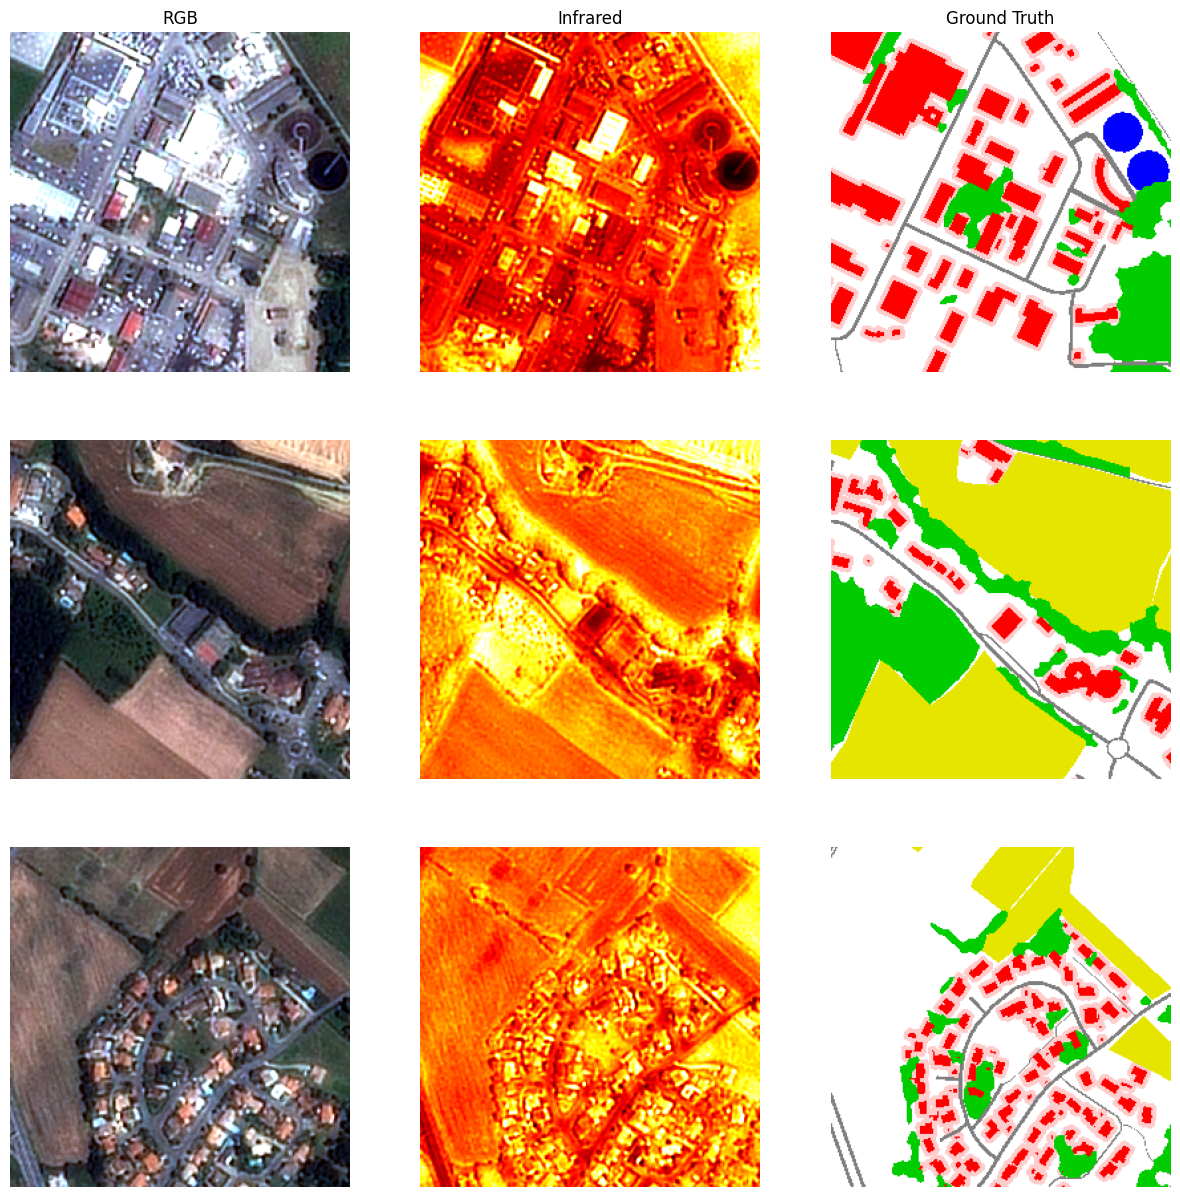

In [17]:
#[6]
viewer(n_shown = 3, category = 'cig', train = True, model = None, use_mask = False)

# 2 Implementation

## Principle

We implement a purely Convolutional Encoder-Decoder (CED) network inspired by SegNet and U-Net.

$\qquad$<img src="https://drive.google.com/uc?id=1bgni2YqkorF-aV9oQfdYO1l7ONAW6FGk" alt="Drawing"  width="700"/>

The first step is to implement a convolutional encoder of an input image which alternates between convolution layers to extract learned features and spatial reduction operations (maxpooling). Once the feature map is small enough, the decoder alternates between convolutions and upsampling (unpooling) to generate an output of the same size of the original input.

We differentiate between the size of a feature map, ie its resolution (eg: $128 \times 128$) and its depth, ie the size of the embeddings of each pixel (eg: $64$)

To help with upsampling, two types of information can be passed from the encoder to the decoder:
 -  Unpooling layer of the decoder can use the indices of the pixels selected in the corresponding maxpooling layer of the encoder. This way, the unpooling layer can localize the original information more precisely. The feature maps must have the same dimension however.
 -  Some feature maps of the encoder are concatenated to the corresponding feature maps of the decoder as long as they have the same size (not necessarily the same depth), in order to bypass high resolution information.


## Description

 The CED takes an image of dimension $C \times H \times W$ with $H \times W$ the size of the image and $C$ the number of channels (ie. the depth of the input). In this exercise $H=W=256$ and $C=4$ (RGB + infrared). The channels are normalized in the $[0,1]$ range.

 The objective is to obtain a prediction map $y$ of size $H \times W \times K$ where K is the number of semantic classes, and $y_{i,j,k}$ is the class score of pixel $i,j$ for class $k$. Class probabilities can be obtained from class scores with the `softmax` function.

We write here the equation for a CED with 3 levels $a, b$ and $c$. The network is composed of $5$ convolutional block composed each of two convolution of kernel $3\times 3$. The $i$-th block is composed of $\text{Conv}{i0}$ and $\text{Conv}{i1}$. The convolutions of block $i$ have a width of $d_i$ for $i=0 \cdots 4$. In other words, $\text{Conv}_{i0}: d_{i-1} \mapsto d_i$ and  $\text{Conv}_{i1}: d_{i} \mapsto d_i$.

Each convolution is followed by a batch normalization unit, and a ReLu non-linearity. The last layer $\text{Conv}{D}$ is a $1\times 1$ convolution, directly mapping the pixels' embeddings to the class scores (with neither normalization nor activation).

$$\newcommand{\Conv}[2]{\text{Conv}_{#1}\left(#2\right)}$$
$$\newcommand{\Maxpool}[1]{\text{Maxpool}\left(#1)\right)}$$
$$\newcommand{\Unpool}[2]{\text{Unpool}\left(#1,#2)\right)}$$
$$\newcommand{\Indices}[2]{\text{indices}_{#1 \rightarrow #2}}$$

\begin{align}
&\textbf{Encoder} \\
&x_1  = \Conv{1}{\text{input}} \\
&x_1^\text{max}, \Indices{a}{b} =  \Maxpool{x_1} \\
&x_2  = \Conv{2}{x_1^\text{max}} \\
&x_2^\text{max}, \Indices{b}{c}  = \Maxpool{x_2} \\
&x_3  = \Conv{3}{x_2^\text{max}} \\
&\textbf{Decoder} \\
&x_3^\text{up}  = \Unpool{x_3}{\Indices{b}{c}} \\
&x_4  = \Conv{4}{[x_3^\text{up}, x_2]}\\
&x_4^\text{up} = \Unpool{x_4}{\Indices{a}{b}} \\
&x_5  = \Conv{5}{[x_4^\text{up}, x_1]}\\
&y  = \Conv{D}{x_5}
\end{align}

All convolutions except the last one have a kernel of size $3\times 3$ and use mirror padding. The last convolution $\text{Conv}_D$ has a kernel of size $1\times 1$. We denote by $d_n$ the width of convolution $n$ (ie. size of the produced feature map). The size of the tensor above is given in the table below:

> **Tensor**           |    **shape of the considered tensors**   |
> -------------------- | -------------------------------------------------|
> input                |  $4 \times H \times W$                           |
> $x_1$                |  $d_0 \times H\times W$                          |
> $x_1^\text{max}$     |  $d_0 \times \lceil{H}/{2}\rceil\times \lceil{W}/{2}\rceil$|
> $x_2$                |  $d_1 \times \lceil{{H}/{2}}\rceil\times \lceil{{W}/{2}}\rceil$|
> $x_2^\text{max}$     |  $d_1 \times \lceil{{H}/{4}}\rceil\times \lceil{{W}/{4}}\rceil$|
> $x_3$                |  $d_2 \times \lceil{{H}/{4}}\rceil\times \lceil{{W}/{4}}\rceil$|
> $x_3^\text{up}$      |  $d_2 \times \lceil{{H}/{2}}\rceil\times \lceil{{W}/{2}}\rceil$|
> $x_4$                |  $d_3 \times \lceil{{H}/{2}}\rceil\times \lceil{{W}/{2}}\rceil$|
> $x_4^\text{up}$      |  $d_3 \times H \times W$
> $x_5$                |  $d_4 \times H \times W$
> $y$                  |  $K \times H \times W$

Q3) Complete the class SegNet below by completing the shape layers in `__init__` and implementing the networks' equations in `forward`.

<font color='red'>Give the formula for the number of parameters (weights) in  $\text{Conv}_1$, $\text{Conv}_{4}$, and  $\text{Conv}_{D}$ (don't forget the biases).</font>


*   Conv1 = 3 * 3 * c* d1<font color='red'>[poid]</font> + d1<font color='red'>[biais]</font>
*   Conv4 = 3 * 3 (d2 * d3) * d4<font color='red'>[poid]</font> + d4<font color='red'>[biais]</font>
*   ConvD = 1 * 1 (d5) * 5<font color='red'>[poid]</font> + k<font color='red'>[biais]</font>


In [18]:
#[9]
class SegNet(nn.Module):
  """
  SegNet network for semantic segmentation
  """

  def __init__(self, n_channels, conv_width,  n_class, cuda = 1):
    """
    initialization function
    n_channels, int, number of input channel
    conv_width, int list, depth of the convs [d0,d1,d2,d3,d4]: list of 5 integers
    n_class = int,  the number of classes
    """
    super(SegNet, self).__init__() #necessary for all classes extending the module class

    self.is_cuda = cuda

    #checks that the conv widths are compatible, throws an error otherwise
    assert((conv_width[0] == conv_width[3]) \
     and (conv_width[1] == conv_width[2]))

    self.maxpool = nn.MaxPool2d(2,2,return_indices=True) #maxpooling layer
    self.unpool = nn.MaxUnpool2d(2,2) #unpooling layer
    #encoder (remember that conv_{i0} and conv_{i1} have the same width d_i = conv_width[i]
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=n_channels, out_channels=conv_width[0] , kernel_size=3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(conv_width[0]), nn.ReLU(True))
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=conv_width[0], out_channels=conv_width[1], kernel_size=3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(conv_width[1]), nn.ReLU(True))
    self.conv3  = nn.Sequential(
        nn.Conv2d(in_channels=conv_width[1], out_channels=conv_width[2], kernel_size=3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(conv_width[2]),nn.ReLU(True))
    #decoder
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=conv_width[2]+conv_width[1], out_channels=conv_width[3], kernel_size=3,padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(conv_width[3]), nn.ReLU(True))
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=conv_width[3] + conv_width[0], out_channels=conv_width[4], kernel_size=3, padding=1, padding_mode='reflect'),
        nn.BatchNorm2d(conv_width[4]), nn.ReLU(True))
    #final classifying layer
    #this layer has a kernel size of 1, meaning it operates on each pixels independently
    self.convD = nn.Conv2d(in_channels=conv_width[4], out_channels=n_class, kernel_size=1, padding=0)

    if cuda: #put the model on the GPU memory
         self.cuda()

  def forward(self,input):
    """
    the function called to run inference
    """
    if self.is_cuda: #put the data on the GPU
      input = input.cuda()
    #-----encoder----
    #level 1
    x1 = self.conv1(input)
    x1max, indices_1_2 = self.maxpool(x1)
    #level 2
    x2 = self.conv2(x1max)
    x2max, indices_2_3 = self.maxpool(x2)
    #level 3
    x3 = self.conv3(x2max)
    #----decoder----
    #level 2
    #the unpooling uses the indices of where the max values were in the b->c maxpooling
    x3up = self.unpool(x3, indices_2_3)
    x4 = self.conv4(torch.cat((x3up,x2),1))
    #level 1
    x4up = self.unpool(x4, indices_1_2)
    x5 = self.conv5(torch.cat((x4up, x1), 1))
    #output
    out = self.convD(x5)
    return out

Q4) Some asserts were added in the `__init__` functions. <font color='red'>Why is  necessary that $d_1=d_2$ and $d_0=d_3$</font>?

Q5) Make sure that following verification code passes without error

In [19]:
#[10]
#==================TEST===============================
#we consider the first point cloud from the training set
tile, gt = tile_loader(0)
segnet = SegNet(4,[32,64,64,32,32],6)
print(segnet)
print('Total number of parameters: {}'.format(sum([p.numel() for p in segnet.parameters()])))
pred = segnet(tile[None,:,:,:]) #the None indicate a batch size of 1
assert(pred.shape == torch.Size([1,6,256,256]))

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

Q6) Complete the metric functions belows, defined with respect to the confusion matrix $C$ of size $k \times k$:

* *Overall Accuracy*: a global metric defined as the ratio of correct prediction divided by the number of (annotated) points
    $$
    OA =
    \frac{\sum_{i}C_{i,i}}
    {\sum_{i,j}C_{i,j}}.
    $$
* *Class IoU*: this per-class metric is defined as the ratio between true positives divided by the sum of false positives, false negatives and true positives.
    $$
    IoU_i = \frac{C_{i,i}}
    {C_{i,i} + \sum_{j \neq i}\left(C_{i,j} + C_{j,i} \right)}
    .
    $$


Make sure to obtain:
make sure you obtain the following:

```OA = 85.00%```

```
Urban : 71.43%  |  Water : 57.14%  |  Fields : 100.00%  |  Road : 100.00%  |  Vegetation : 100.00%  |  Buildings : 66.67%
```

In [1]:
#[7]
class ConfusionMatrix:
  def __init__(self, n_class, class_names):
    self.CM = np.zeros((n_class, n_class))
    self.n_class = n_class
    self.class_names = class_names

  def clear(self):
    self.CM = np.zeros((self.n_class, self.n_class))

  def add_batch(self, gt, pred):
    self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))

  def overall_accuracy(self):#percentage of correct classification
    return np.trace(self.CM) / np.sum(self.CM)#TODO hint: use np.trace

  def class_IoU(self, show = 1):
    ious = np.diag(self.CM) / (np.sum(self.CM, axis=1) + np.sum(self.CM, axis=0) - np.diag(self.CM))#TODO hint, use np.diag
    if show:
      print('  |  '.join('{} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    #do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [21]:
#[8]
m = ConfusionMatrix(6, class_names)
m.add_batch(np.array([0,1,1,5,2,0,0,4,0,5,3]), np.array([0,1,0,5,2,0,1,4,0,5,3]))
m.add_batch(np.array([0,1,5,1,2,1,0,2,3]), np.array([0,1,1,1,2,1,0,2,3]))
print(m.CM)
print("OA = %3.2f%%" % (100*m.overall_accuracy()))
m.class_IoU()
m.clear()

[[5. 1. 0. 0. 0. 0.]
 [1. 4. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 2.]]
OA = 85.00%
Urban : 71.43%  |  Water : 57.14%  |  Fields : 100.00%  |  Road : 100.00%  |  Vegetation : 100.00%  |  Buildings : 66.67%


Q7) Read in the `train` function following cell. Complete the function `eval`  which performs inference with the trained model. This function computes the loss but does not compute gradients nor make an optimizer step.

In [24]:
#[11]
def train(model, optimizer, args):
  """train for one epoch"""
  model.train() #switch the model in training mode

  #the loader function will take care of the batching
  loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  #tqdm will provide some nice progress bars
  loader = tqdm(loader, ncols=500)

  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  #keep tracks of prediction errors
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  for index, (tiles, gt) in enumerate(loader):

    if model.is_cuda: #put the ground truth on the GPU
        gt = gt.cuda()

    optimizer.zero_grad() #put gradient to zero

    pred = model(tiles) #compute the prediction

    loss = nn.functional.cross_entropy(pred,gt, ignore_index=99) #compute the loss

    loss.backward() #compute gradients

    optimizer.step() #one SGD step

    loss_meter.add(loss.item())

    gt = gt.cpu() #back on the RAM

    labeled = np.where(gt.view(-1)!=99)[0] #select gt with a label, ie not 99
    #need to put the prediction back on the cpu and convert to numpy before feeding it to the CM
    cm.add_batch(gt.view(-1)[labeled], pred.argmax(1).view(-1)[labeled].cpu().detach().numpy())

  return cm, loss_meter.value()[0]

def eval(model, args, test=True):
  """eval on test/validation set"""

  model.eval() #switch in eval mode

  if test: #test set
    loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False)
  else:
    loader = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=False, drop_last=False)

  loader = tqdm(loader, ncols=500, leave=False, desc="Validation")

  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  with torch.no_grad(): #do not compute gradients (saves memory)
    for index, (tiles, gt) in enumerate(loader):
        if model.is_cuda:
          gt = gt.cuda()
        pred = model(tiles)
        loss = nn.functional.cross_entropy(pred,gt, ignore_index=99)
        loss_meter.add(loss.item())

        gt = gt.cpu()
        labeled = np.where(gt.view(-1)!=99)[0]
        cm.add_batch(gt.view(-1)[labeled], pred.argmax(1).view(-1)[labeled].cpu().detach().numpy())

  return cm, loss_meter.value()[0]


def train_full(args):
  """The full training loop"""
  #initialize the model

  model = SegNet(args.n_channel, args.conv_width, args.n_class)

  print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))

  #define the optimizer
  #Adam optimizer is always a good guess for classification tasks
  optimizer = optim.Adam(model.parameters(), lr=args.lr)

  #defines some color for test and train texts
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  NORMALCOLOR = '\033[0m'

  for i_epoch in tqdm(range(args.n_epoch), desc="Training"):
    #train one epoch
    cm_train, loss_train = train(model, optimizer, args)
    tqdm.write(TRAINCOLOR + 'Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), cm_train.class_IoU(False), loss_train) + NORMALCOLOR)

    if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
      #periodic testing
      cm_test, loss_test = eval(model, args)
      tqdm.write(TESTCOLOR + 'Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), cm_test.class_IoU(), loss_test) + NORMALCOLOR)
      viewer(n_shown = 1, train = False, model = model, category = 'cigpe', use_mask = False)
  return model

Q8) Train a model with the default parameter in the following cell.

In [25]:
#[12]
args = mock.Mock() #stores the parameters
args.n_epoch = 50
args.n_epoch_test = int(1) #periodicity of evaluation on test set
args.batch_size = 16
args.n_class = 6
args.n_channel = 4
args.conv_width = [32,64,64,32,16]
args.cuda = 1
args.lr = 5e-3

trained_model = train_full(args)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

Q9) Visualize the values RGB, Infrared,  ground truth, prediction and error for 5 random tiles of the test set. Visualize with and without the masks.  <font color='red'>Propose an explanation as to why the pink class surrounding the buildings was added.</font>

**Hint1:** run an experiment to show the effect of having this class or not.

**Hint2:** the dataloader is the perfect place to transform the ground truth.

In [26]:
#[13]
viewer(n_shown = 3, category = 'cigpe', train = False, model = trained_model, use_mask = False)

NameError: name 'trained_model' is not defined

Q10)  We now visualize the feature maps at different step. Complete the following function to visualize the feature maps of a model. Launch this viewer on a fully trained model.

In [27]:
#[14]
def view_embeddings(fmap, ax = None):
  """
  visualize a feature_map in RGB space
  """
  if ax==None:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
  fmap_dim = fmap.shape[1]
  n_pix = fmap.shape[2]
  #we use a pca to project the emebddings to a RGB space
  pca = PCA(n_components=3)
  pca.fit(np.eye(fmap_dim))
  #we need to adapt dimension and memory allocation to CPU
  fmap_ = fmap.cpu().detach().numpy().squeeze().reshape((fmap_dim, n_pix * n_pix)).transpose(1,0)
  color = pca.transform(fmap_)
  #we normalize for visibility
  color = np.maximum(np.minimum(((color - color.mean(1, keepdims = True) +0.5) / (2 * color.std(1, keepdims = True))), 1), 0)
  color = color.reshape((n_pix, n_pix,3), order= 'C')
  ax.imshow(color)
  plt.axis('off')

def view_U(model, tile_index = None, train = False):
  """
  view the feature maps at all levels for a give model
  model = a trained model
  tile_index = a specific tile index
  train = if True, visualize on train set
  """
  if tile_index is None:
    tile_index = np.random.randint(n_train) if train \
    else np.random.randint(n_test)
  tile, gt = tile_loader(tile_index, train = train)

  input = tile[None,:,:,:]
  input = input.cuda()
  #-----encoder----
  #level 1
  x1 = model.conv1(input)
  x1max, indices_1_2 = model.maxpool(x1)
  #level 2
  x2 = model.conv2(x1max)
  x2max, indices_2_3 = model.maxpool(x2)
  #level 3
  x3 = model.conv3(x2max)
  #----decoder----
  #level 2
  #the unpooling uses the indices of where the max values were in the b->c maxpooling
  x3up = model.unpool(x3, indices_2_3)
  x4 = model.conv4(torch.cat((x3up,x2),1))
  #level 1
  x4up = model.unpool(x4, indices_1_2)
  x5 = model.conv5(torch.cat((x4up, x1), 1))
  #output
  out = model.convD(x5)
  pred = out.argmax(1)

  fig = plt.figure(figsize=(25, 10)) #adapted dimension
  ax = fig.add_subplot(3, 7, 1, aspect=1)
  ax.set(title='Input : %d x %d x %d' %(tile.shape))
  view_rgb(tile.cpu(), ax)
  ax = fig.add_subplot(3, 7, 2, aspect=1)
  ax.set(title='x1 : %d x %d x %d' %(x1.shape[1:]))
  view_embeddings(x1, ax)
  ax = fig.add_subplot(3, 7, 9, aspect=1)
  ax.set(title='x1max : %d x %d x %d' %(x1max.shape[1:]))
  view_embeddings(x1max, ax)
  ax = fig.add_subplot(3, 7, 10, aspect=1)
  ax.set(title='x2 : %d x %d x %d' %(x1.shape[1:]))
  view_embeddings(x2, ax)
  ax = fig.add_subplot(3, 7, 17, aspect=1)
  ax.set(title='x2max : %d x %d x %d' %(x2max.shape[1:]))
  view_embeddings(x2max, ax)
  ax = fig.add_subplot(3, 7, 18, aspect=1)
  ax.set(title='x3 : %d x %d x %d' %(x3.shape[1:]))
  view_embeddings(x3, ax)
  ax = fig.add_subplot(3, 7, 11, aspect=1)
  ax.set(title='x3up : %d x %d x %d' %(x3up.shape[1:]))
  view_embeddings(x3up, ax)
  ax = fig.add_subplot(3, 7, 12, aspect=1)
  ax.set(title='x4 : %d x %d x %d' %(x4.shape[1:]))
  view_embeddings(x4, ax)
  ax = fig.add_subplot(3, 7, 5, aspect=1)
  ax.set(title='x4up : %d x %d x %d' %(x4up.shape[1:]))
  view_embeddings(x4up, ax)
  ax = fig.add_subplot(3, 7, 6, aspect=1)
  ax.set(title='x5 : %d x %d x %d' %(x5.shape[1:]))
  view_embeddings(x4, ax)
  ax = fig.add_subplot(3, 7, 7, aspect=1)
  ax.set(title='Output : 6 x %d x %d' %(tile.shape[1:]))
  view_labels(pred.cpu().detach().numpy().squeeze(), ax)
  ax = fig.add_subplot(3, 7, 14, aspect=1)
  ax.set(title='Ground Truth : 6 x %d x %d' %(tile.shape[1:]))
  view_labels(gt, ax)
  ax = fig.add_subplot(3, 7, 21, aspect=1)
  ax.set(title='Error')
  view_error(pred.cpu().detach().numpy().squeeze(), gt.numpy(), ax)

In [28]:
#[15]]
view_U(trained_model)

NameError: name 'trained_model' is not defined

$\star$ Q11) The performance on the test set fluctuate a lot. We implement a validation set to select the best epoch. Replace `train_full` by the following code once completed:  

In [ ]:
def train_full(args):
  """The full training loop"""
  #initialize the model

  model = SegNet(args.n_channel, args.conv_width, args.n_class)

  print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))

  best_model = None
  best_mIoU = #TODO worst miou possible

  #define the optimizer
  #Adam optimizer is always a good guess for classification tasks
  optimizer = optim.Adam(model.parameters(), lr=args.lr)

  #defines some color for test and train texts
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  NORMALCOLOR = '\033[0m'
  VALIDCOLOR = '\033[45m' #new color

  for i_epoch in tqdm(range(args.n_epoch), desc="Training"):
    #train one epoch
    cm_train, loss_train = train(model, optimizer, args)
    mIoU_train = cm_train.class_IoU(False)
    tqdm.write(TRAINCOLOR + 'Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), mIoU_train, loss_train) + NORMALCOLOR)

    cm_valid, loss_valid =  eval(model, args, test=False) #test on eval set
    mIoU_valid = cm_valid.class_IoU(False)
    best_valid = False

    if #TODO: check that mIoU_valid is the highest yet
      best_valid = True
      best_mIoU = #TODO update best iou
      best_model = copy.deepcopy(model) #♥copy the current model
      tqdm.write(VALIDCOLOR + '-> Best performance achieved: Overall Accuracy: %3.2f%% valid mIoU : %3.2f%% valid Loss: %1.4f' % (cm_valid.overall_accuracy(), best_mIoU, loss_valid) + NORMALCOLOR)
    else:
      tqdm.write(NORMALCOLOR + 'Subpar performance: Overall Accuracy: %3.2f%% valid mIoU : %3.2f%% valid Loss: %1.4f' % (cm_valid.overall_accuracy(), best_mIoU, loss_valid) + NORMALCOLOR)

    if best_valid or i_epoch == args.n_epoch - 1:
      cm_test, loss_test = eval(model, args, test=True)#eval on test set
      mIoU_test = cm_test.class_IoU()
      tqdm.write(TESTCOLOR + 'Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), mIoU_test, loss_test) + NORMALCOLOR)

  return best_model #return the best model, not necessarily the last one

$\star$ Q12) Use the code below to add a step at the end of training in which we plot the evolution of train, val, and test loss and IoU. Careful! The code below does not incorporate a validation set. If you completed Q10, you need to combine the two codes.

HINT: set args.n_epoch to 2 for faster debugging!

HINT: use `plt.ylim` to set reasonnable values for `ymin` and `ymax` to really see the important part of the graph.


In [ ]:
def train_full(args):
  """The full training loop"""
  #initialize the model

  model = SegNet(args.n_channel, args.conv_width, args.n_class)

  #[...]

  train_metrics = -np.ones((args.n_epoch, 3)) #epoch / loss/ miou
  test_metrics = -np.ones((args.n_epoch, 3))

  for i_epoch in tqdm(range(args.n_epoch), desc="Training"):
    #train one epoch
    #[...]

    train_metrics[i_epoch, 0] = #TODO:epoch
    train_metrics[i_epoch, 1] = #TODO:loss
    train_metrics[i_epoch, 2] = #TODO:miou

    if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
      #[...]

      test_metrics[i_epoch, 0] = #TODO:epoch
      test_metrics[i_epoch, 1] = #TODO:loss
      test_metrics[i_epoch, 2] = #TODO:miou

      viewer(n_shown = 1, train = False, model = model, category = 'cigpe', use_mask = False)

  #PLOTTING
  test_metrics = test_metrics[test_metrics[:, 0] != -1]
  plt.subplot(121)
  plt.plot(train_metrics[:, 0], train_metrics[:, 1], label="train")
  plt.plot(test_metrics[:, 0], test_metrics[:, 1], label="test")
  plt.legend(loc="best")
  plt.title("Loss")
  plt.subplot(122)
  plt.plot(train_metrics[:, 0], train_metrics[:, 2], label="train")
  plt.plot(test_metrics[:, 0], test_metrics[:, 2], label="test")
  plt.legend(loc="best")
  plt.title("mIoU")
  plt.show()
  return model


$\star$Q13 Add a drop out layer on the previous to last layer of the classifier layer. Comment on the effect, if any.


$\star$Q14 The data set is imbalanced. Add class weights to the cross entropy loss to increase the importance of vegetation and buildings (see torch doc). Use the following weight vector:
[0.2,0.1,0.1,0.3,0.1,0.2], and try other values and comment on their effect on the OA and mIoU.

$\star$Q15 Remove the first `return obs, gt` in the function `augment` in the dataloader and complete the code to add a random rotation and a Gaussian perturbation. In particular, assert wethr or not the random rotation helps or not. Explain why such an augmentation might actually hurt the performance in our specific application.

$\star\star$Q16 Remove the skip connection and comment on the quality of the prediction. Then, keep the skip connection but replace the concatenation by residuals layers ($x_4  = \Conv{4}{x_3^{up}+ x_2}$ and $x_5  = \Conv{5}{x_4^{up}+ x_1}$). Comment on the quality of the prediction and the size of the model.

$\star\star$Q17 Create the class `SegNet3` which operates on 4 levels instead of 3 (with the final layer of the encoder being of size $\lceil H/8\rceil \times \lceil W/8 \rceil \times d$. Test this architecture and comment. Don't forget to add the necessary assertions.

$\star\!\star\!\star$Q18 Replace the maxpooling/unpooling with strided convolutions and strided transpose convolutions (stride = 2, kernel = 4)

$\star\!\star\!\star$Q19 We want to increase the spatial regularity of the output by adding a low total variation prior on the prediction. We define $loss\_TV(y)=\sum_{u,v \in E} \sum_{k \in \mathcal{K}} \left\vert y_{u,k} - y_{v,k}\right\vert$ where $\mathcal{K}$ is the set of classes, $y_{u,k}$ is the logit of class $k$ for pixel $u$ and $E$ the $4$-neighbors adjacency structure of the image (use the already implemented function `compute_adjacency_graph` in cell [16] and by completing the function `TV` in cell [17] and the learning functions [18]).

Define the new loss at epoch $t$ as:
$$\texttt{loss}(y) = \text{cross_entropy}(y, gt) + \alpha_t \text{loss_TV}(y)~,$$
with $gt$ the ground truth, and
$$\alpha_t = \alpha_0 \times  \min(1, t/ \text{n_epochsTV})~,$$
 with $\alpha_0$ the regulation strength (take 0.1) and $\text{n_epochsTV}$ the number of epochs to before the TV regulairzation is at *full strength* (here max_epoch/2).

Try different values of $\alpha_0$ and comment on the effect on the accuracy and the spatial regularity of the output. Why is annealing necessary here? What would happened to the network if we started with hig regularization strength from the beginning of training.

In [ ]:
#[16]
def compute_adjacency_graph(n = 256, cuda = 1):
  """
  compute the 4-adjacency graph for a square image of size n
  return a matrix E of size M x 4 with M the number of edges
  M[i,:2] is the coordinates of the origin of the edge
  M[i,2:] is the coordinates of the target of the edges
  """
  edges = np.zeros((2*n**2,4), dtype='int64')
  index_edg = 0
  for row in range(n):
    for col in range(n):
      if row < n-1:
        edges[index_edg,:] = [row,col,row+1,col]
        index_edg += 1
      if j < n-1:
        edges[index_edg,:] = [row,col,row,col+1]
        index_edg += 1
  return edges[:index_edg,:]

In [ ]:
#[17]
def TV(x,edges):
  return torch.abs(#TODO).mean()

In [ ]:
#[18]
def train_TV(model, optimizer, edges, weight_TV, args):
  """train for one epoch"""
  #TODO

  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  loss_acc_meter = tnt.meter.AverageValueMeter()
  loss_TV_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  for index, (tiles, gt) in enumerate(loader):

    #TODO

    loss = loss_acc + loss_TV * weight_TV

    #TODO

  return cm, loss_meter.value()[0], loss_acc_meter.value()[0], loss_TV_meter.value()[0]

def eval_TV(model, edges, weight_TV, args):
  """eval on test/validation set"""

  model.eval() #switch in eval mode

  #TODO

  return cm, loss_meter.value()[0], loss_acc_meter.value()[0], loss_TV_meter.value()[0]

def train_full_TV(args):
  """The full training loop"""
  #initialize the model

  model = SegNet(args.n_channel, args.conv_width, args.dconv_width, args.n_class)

  edges = compute_adjacency_graph(256)

  print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))

  #define the optimizer
  #adam optimizer is always a good guess for classification
  optimizer = optim.Adam(model.parameters(), lr=args.lr)

  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  NORMALCOLOR = '\033[0m'

  for i_epoch in tqdm(range(args.n_epoch), desc="Training"):
    #train one epoch
    weight_TV = args.weight_TV_base * min(1, i_epoch / args.n_epochTV)
    cm_train, loss_train, loss_acc_train, loss_TV_train = train_TV(model, optimizer, edges, weight_TV, args)
    print(TRAINCOLOR)
    print('Epoch %3d -> Overall Accuracy: %3.2f%% mIoU : %3.2f%% Acc Loss: %1.4f TV Loss: %1.4f Loss: %1.4f' % \
          (i_epoch, cm_train.overall_accuracy(), cm_train.class_IoU(), loss_acc_train, loss_TV_train, loss_train) + NORMALCOLOR)

    if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
      #periodic testing
      cm_test, loss_test, loss_acc_test, loss_TV_test = eval_TV(model, edges, weight_TV, args)
      print(TESTCOLOR)
      print('Epoch %3d -> Overall Accuracy: %3.2f%% mIoU : %3.2f%% Acc Loss: %1.4f TV Loss: %1.4f Loss: %1.4f' % \
          (i_epoch, cm_test.overall_accuracy(), cm_test.class_IoU(), loss_acc_test, loss_TV_test, loss_test) + NORMALCOLOR)
      viewer(n_shown = 1, train = False, model = model, category = 'cigpe', use_mask = False)
  return model

In [ ]:
#[19]
args = mock.Mock() #stores the parameters
args.n_epoch = 50
args.n_epoch_test = int(5) #periodicity of evaluation on test set
args.batch_size = 16
args.n_class = 6
args.n_channel = 4
args.conv_width = [32,64,64,32,16]
args.cuda = 1
args.lr = 5e-3
args.n_epochTV = 25
args.weight_TV_base = 0.1

trained_model = train_full_TV(args)


Q20 Open question: try to think of other ways to improve the model, and report your reasoning and results.


# Reference
Badrinarayanan, V., Kendall, A., \& Cipolla, R. (2017). Segnet: A deep convolutional encoder-decoder architecture for image segmentation. IEEE transactions on pattern analysis and machine intelligence, 39(12).

Ronneberger, O., Fischer, P., \& Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham.